In [ ]:
# 스타벅스와 메가커피의 입점 전략 차이 분석 (서울)

## 가설: 스타벅스와 메가커피의 입점 전략은 다를 것이다.
### 1. 지하철 거리: 스타벅스는 비싸도 역세권, 메가커피는 좀 불편해도 사람들이 찾아오게
### 2. kmeans로 클러스터링 방법을 찾은 다음 얼마나 걸리나?

## 스타벅스는 서울과 지방의 입점 전략이 다를 것이다. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

In [51]:
df = pd.read_csv('ml_final_df.csv', encoding='utf-8-sig')
df.shape

(400914, 28)

In [52]:
df.head(1).T

,0
상호명,부동산임대김은숙
상권업종대분류명,음식
상권업종중분류명,비알코올
상권업종소분류명,카페
경도,126.98184
위도,37.58625
근방가게수,638
근방음식점수,153
근방카페수,59
근접역거리,1.123776


In [ ]:
# df 위경도 중심으로 cluster 10개를 만든 후 해당 클러스터로부터 얼마나 떨어져있는지 탐색한다. 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

In [61]:
kmeans = KMeans(n_clusters=10, init="k-means++", random_state=42)
kmeans.fit(X=df[['경도','위도']])
kmeans.cluster_centers_

array([[127.02936237,  37.50307778],
       [126.90084001,  37.48059341],
       [127.04975598,  37.64945281],
       [126.98959521,  37.56289581],
       [127.1293191 ,  37.51245842],
       [126.92015304,  37.52292358],
       [126.84293126,  37.5428847 ],
       [127.08006386,  37.59356642],
       [126.92295304,  37.58039685],
       [127.04538061,  37.55829283]])

In [62]:
kmeans.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'kmeans5',
       'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9'], dtype=object)

In [73]:
df_centers_10 = pd.DataFrame(kmeans.cluster_centers_, columns=['경도','위도'], index=kmeans.get_feature_names_out())
df_centers_10 = df_centers_10.reset_index()
df_centers_10

,index,경도,위도
0,kmeans0,127.029362,37.503078
1,kmeans1,126.900840,37.480593
2,kmeans2,127.049756,37.649453
3,kmeans3,126.989595,37.562896
4,kmeans4,127.129319,37.512458
5,kmeans5,126.920153,37.522924
6,kmeans6,126.842931,37.542885
7,kmeans7,127.080064,37.593566
8,kmeans8,126.922953,37.580397
9,kmeans9,127.045381,37.558293


In [70]:
from sklearn.neighbors import BallTree

def closest_radian(df1, df2, df2_col, lat_col='위도', lon_col='경도'):
    # 좌표를 라디안으로 변환
    df1_coords = np.radians(df1[[lat_col, lon_col]].to_numpy())
    df2_coords = np.radians(df2[[lat_col, lon_col]].to_numpy())

    # BallTree 생성 (haversine 거리 사용)
    tree = BallTree(df2_coords, metric='haversine')

    # 각 df1 좌표에 대해 가장 가까운 df2 좌표 인덱스 및 거리 추출
    distances, indices = tree.query(df1_coords, k=1)

    # 거리: 라디안 → km (지구 반지름 6371km 사용)
    distances_km = distances.flatten() * 6371

    # 가장 가까운 df2의 특정 컬럼 값 추출
    closest_values = df2.iloc[indices.flatten()][df2_col].reset_index(drop=True)

    # 반환: 거리(km), df2_col
    return distances_km, closest_values

In [74]:
dist, cluster = closest_radian(df1=df, df2=df_centers_10, df2_col='index')

In [ ]:
df['중심점거리'] = dist
df['중심점'] = cluster.values


0         kmeans3
1         kmeans0
2         kmeans9
3         kmeans3
4         kmeans1
           ...   
400909    kmeans7
400910    kmeans7
400911    kmeans7
400912    kmeans7
400913    kmeans7
Name: 중심점, Length: 400914, dtype: object

## EDA

In [82]:
df.head(1).T

,0
상호명,부동산임대김은숙
상권업종대분류명,음식
상권업종중분류명,비알코올
상권업종소분류명,카페
경도,126.98184
위도,37.58625
근방가게수,638
근방음식점수,153
근방카페수,59
근접역거리,1.123776


In [115]:
# df_megamgc = 
cond = (df['상호명'].str.contains('메가커피')) | (df['상호명'].str.contains('메가엠지씨'))
print(df[cond].shape)
df_megamgc = df[cond]

(619, 30)


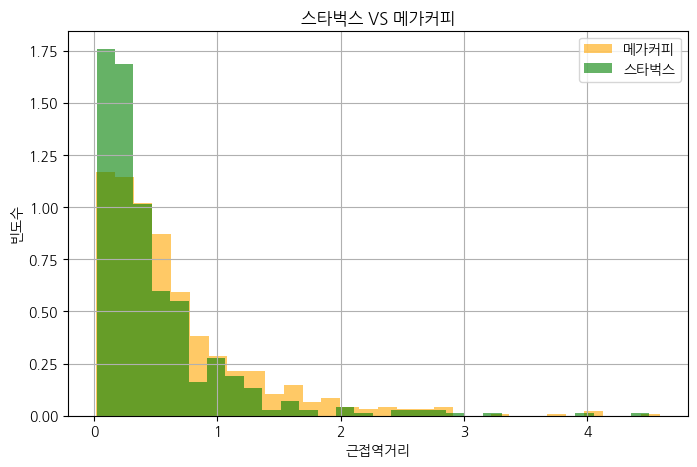

In [121]:
df_starbucks = df[df['스타벅스여부']==1]

plt.figure(figsize=(8, 5))
plt.hist(df_megamgc['근접역거리'], bins=30, alpha=0.6, label='메가커피', color='orange', density=True)
plt.hist(df_starbucks['근접역거리'], bins=30, alpha=0.6, label='스타벅스', color='green', density=True)

plt.xlabel('근접역거리')
plt.ylabel('빈도수')
plt.title('스타벅스 VS 메가커피')
plt.legend()
plt.grid(True)
plt.show()

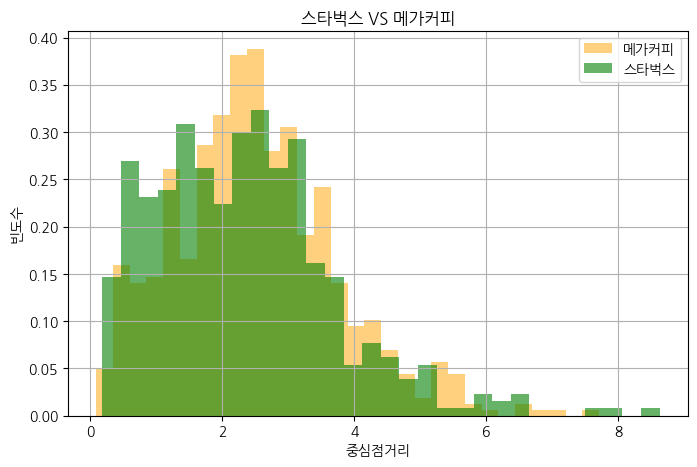

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df_megamgc['중심점거리'], bins=30, alpha=0.5, label='메가커피', color='orange', density=True)
plt.hist(df_starbucks['중심점거리'], bins=30, alpha=0.6, label='스타벅스', color='green', density=True)

plt.xlabel('중심점거리')
plt.ylabel('빈도수')
plt.title('스타벅스 VS 메가커피')
plt.legend()
plt.grid(True)
plt.show()

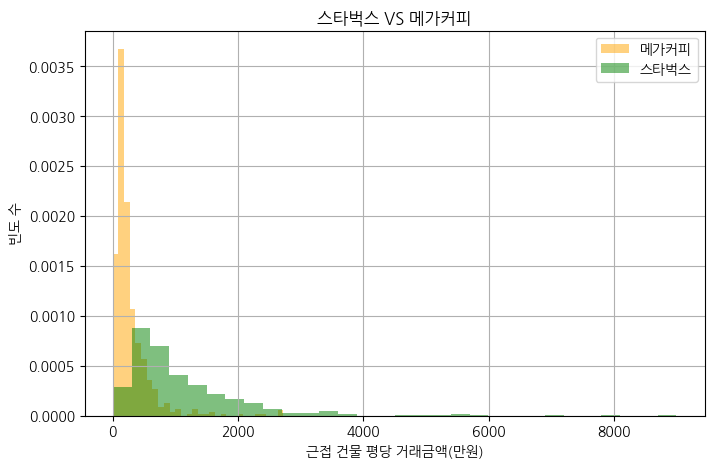

In [123]:
plt.figure(figsize=(8,5))
plt.hist(df_megamgc['평당거래금액(만원)'], density=True, bins=30, alpha=0.5, label='메가커피', color='orange')
plt.hist(df_starbucks['평당거래금액(만원)'], density=True, bins=30, alpha=0.5, label='스타벅스', color='green')

plt.xlabel('근접 건물 평당 거래금액(만원)')
plt.ylabel('빈도 수')
plt.title('스타벅스 VS 메가커피')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, '스타벅스 VS 메가커피')

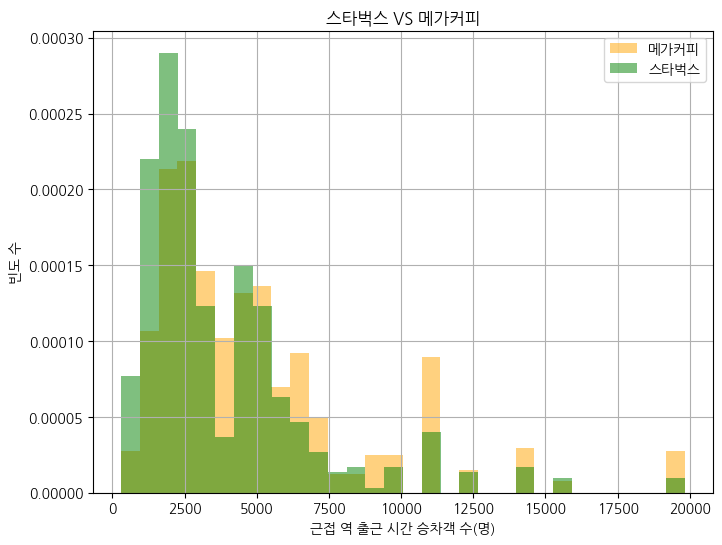

In [124]:
plt.figure(figsize=(8,6))
plt.hist(data=df_megamgc, x='승차_출근시간대', color='orange', density=True, alpha=0.5, bins=30, label='메가커피')
plt.hist(data=df_starbucks, x='승차_출근시간대', color='green', density=True, alpha=0.5, bins=30, label='스타벅스')

plt.xlabel('근접 역 출근 시간 승차객 수(명)')
plt.ylabel('빈도 수')
plt.legend()
plt.grid()
plt.title('스타벅스 VS 메가커피')

Text(0.5, 1.0, '스타벅스 VS 메가커피')

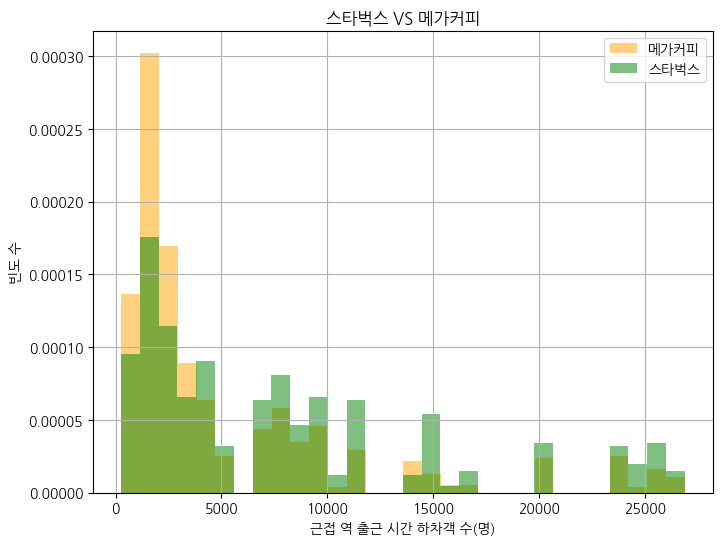

In [125]:
plt.figure(figsize=(8,6))
plt.hist(data=df_megamgc, x='하차_출근시간대', color='orange', density=True, alpha=0.5, bins=30, label='메가커피')
plt.hist(data=df_starbucks, x='하차_출근시간대', color='green', density=True, alpha=0.5, bins=30, label='스타벅스')

plt.xlabel('근접 역 출근 시간 하차객 수(명)')
plt.ylabel('빈도 수')
plt.legend()
plt.grid()
plt.title('스타벅스 VS 메가커피')

Text(0.5, 1.0, '스타벅스 VS 메가커피')

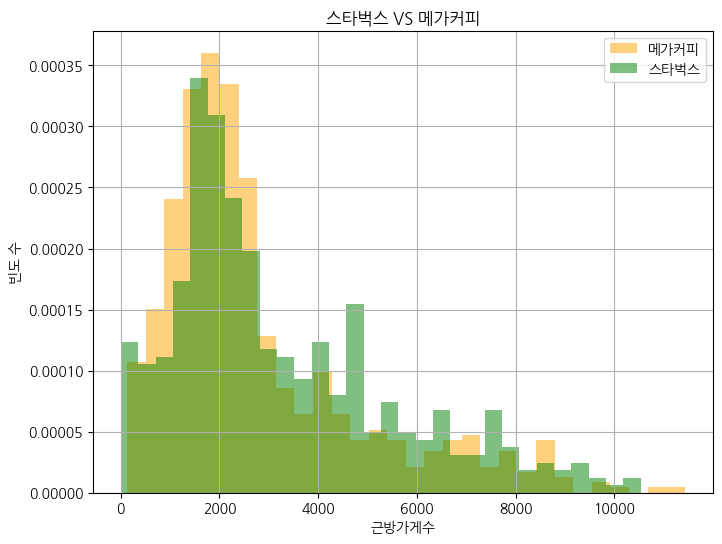

In [126]:
plt.figure(figsize=(8,6))
plt.hist(data=df_megamgc, x='근방가게수', color='orange', density=True, alpha=0.5, bins=30, label='메가커피')
plt.hist(data=df_starbucks, x='근방가게수', color='green', density=True, alpha=0.5, bins=30, label='스타벅스')

plt.xlabel('근방가게수')
plt.ylabel('빈도 수')
plt.legend()
plt.grid()
plt.title('스타벅스 VS 메가커피')

In [133]:
# df_megamgc['0세_6세'] = df_megamgc['0세_6세'] / df_megamgc['계']
# df_megamgc['7세_19세'] = df_megamgc['7세_19세'] / df_megamgc['계']
# df_megamgc['20세_25세'] = df_megamgc['20세_25세'] / df_megamgc['계']
# df_megamgc['26세_30세'] = df_megamgc['26세_30세'] / df_megamgc['계']
# df_megamgc['31세_40세'] = df_megamgc['31세_40세'] / df_megamgc['계']
# df_megamgc['41세_50세'] = df_megamgc['41세_50세'] / df_megamgc['계']
# df_megamgc['51세_60세'] = df_megamgc['51세_60세'] / df_megamgc['계']
# df_megamgc['61세_109세'] = df_megamgc['61세_109세'] / df_megamgc['계']

In [135]:
# df_megamgc['0세_6세'] = df_megamgc['0세_6세'] * 100
# df_megamgc['7세_19세'] = df_megamgc['7세_19세'] * 100
# df_megamgc['20세_25세'] = df_megamgc['20세_25세'] * 100
# df_megamgc['26세_30세'] = df_megamgc['26세_30세'] * 100
# df_megamgc['31세_40세'] = df_megamgc['31세_40세'] * 100
# df_megamgc['41세_50세'] = df_megamgc['41세_50세'] * 100
# df_megamgc['51세_60세'] = df_megamgc['51세_60세'] * 100
# df_megamgc['61세_109세'] = df_megamgc['61세_109세'] * 100

In [139]:
df_starbucks['0세_6세'] = df_starbucks['0세_6세'] / df_starbucks['계']
df_starbucks['7세_19세'] = df_starbucks['7세_19세'] / df_starbucks['계']
df_starbucks['20세_25세'] = df_starbucks['20세_25세'] / df_starbucks['계']
df_starbucks['26세_30세'] = df_starbucks['26세_30세'] / df_starbucks['계']
df_starbucks['31세_40세'] = df_starbucks['31세_40세'] / df_starbucks['계']
df_starbucks['41세_50세'] = df_starbucks['41세_50세'] / df_starbucks['계']
df_starbucks['51세_60세'] = df_starbucks['51세_60세'] / df_starbucks['계']
df_starbucks['61세_109세'] = df_starbucks['61세_109세'] / df_starbucks['계']

df_starbucks['0세_6세'] = df_starbucks['0세_6세'] * 100
df_starbucks['7세_19세'] = df_starbucks['7세_19세'] * 100
df_starbucks['20세_25세'] = df_starbucks['20세_25세'] * 100
df_starbucks['26세_30세'] = df_starbucks['26세_30세'] * 100
df_starbucks['31세_40세'] = df_starbucks['31세_40세'] * 100
df_starbucks['41세_50세'] = df_starbucks['41세_50세'] * 100
df_starbucks['51세_60세'] = df_starbucks['51세_60세'] * 100
df_starbucks['61세_109세'] = df_starbucks['61세_109세'] * 100

/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_50306/1564312159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starbucks['0세_6세'] = df_starbucks['0세_6세'] / df_starbucks['계']
/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_50306/1564312159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starbucks['7세_19세'] = df_starbucks['7세_19세'] / df_starbucks['계']
/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_50306/1564312159.py:3: SettingWithCopyWarning: 
A value is tryi

Text(0.5, 1.0, '스타벅스 VS 메가커피')

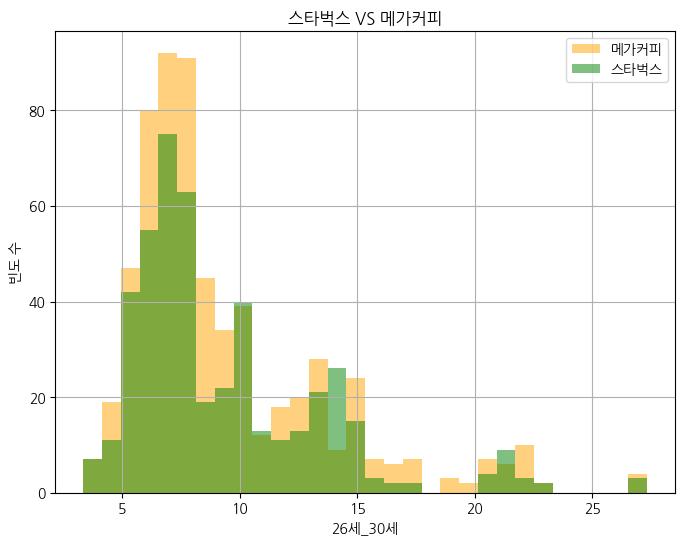

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(data=df_megamgc, x='26세_30세', color='orange',  alpha=0.5, bins=30, label='메가커피')
plt.hist(data=df_starbucks, x='26세_30세', color='green', alpha=0.5, bins=30, label='스타벅스')

plt.xlabel('26세_30세')
plt.ylabel('빈도 수')
plt.legend()
plt.grid()
plt.title('스타벅스 VS 메가커피')



Text(0.5, 1.0, '스타벅스 VS 메가커피')

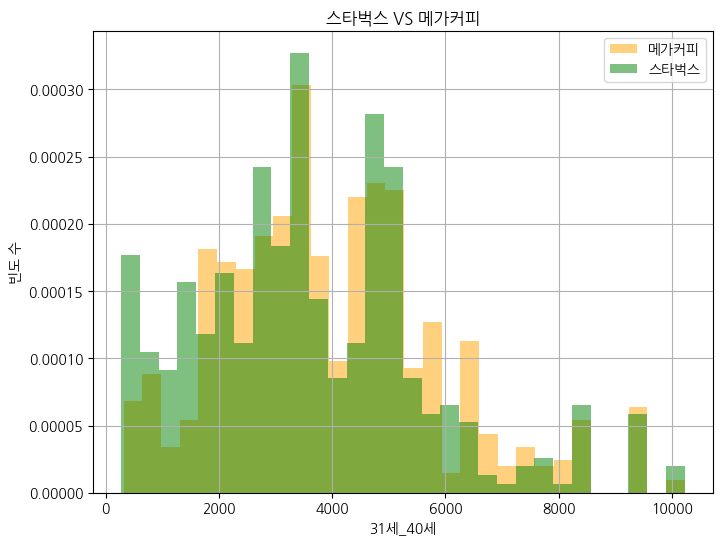

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(data=df_megamgc, x='31세_40세', color='orange', density=True, alpha=0.5, bins=30, label='메가커피')
plt.hist(data=df_starbucks, x='31세_40세', color='green', density=True, alpha=0.5, bins=30, label='스타벅스')

plt.xlabel('31세_40세')

plt.ylabel('빈도 수')
plt.legend()
plt.grid()
plt.title('스타벅스 VS 메가커피')

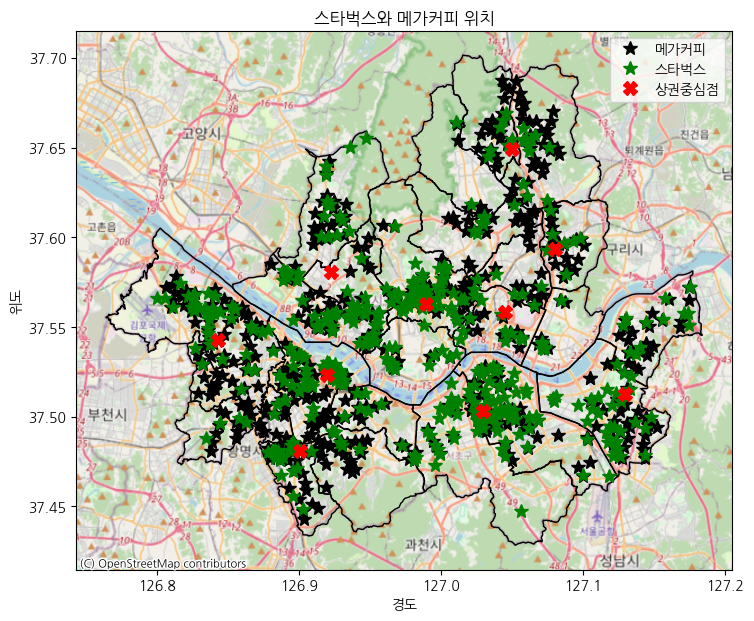

In [143]:
seoul_boundary = gpd.read_file("LARD_ADM_SECT_SGG_11_202502.shp")


# 좌표계 통합 필요
## shapefile 좌표계(crs): EPSG:5179 (TM좌표계, 미터단위)
## housing 데이터: EPSG:4326 (WGS84, 위경도 단위)
seoul_boundary = seoul_boundary.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 7))

seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")

# df_seoul.plot(ax=ax, kind='scatter', x='경도', y='위도', grid=True, cmap="jet", alpha=0.5)

ctx.add_basemap(ax=ax, 
                crs=seoul_boundary.crs, 
                source=ctx.providers.OpenStreetMap.Mapnik)

df_megamgc.plot(
    ax=ax,
    x='경도',
    y='위도', 
    linestyle="", 
    color="black", 
    marker="*", 
    markersize=10, 
    label="메가커피")


df_starbucks.plot(
    ax=ax,
    x='경도',
    y='위도', 
    linestyle="", 
    color="green", 
    marker="*", 
    markersize=10, 
    label="스타벅스")

df_centers_10.plot(ax=ax,
                  x='경도',
                  y='위도',
                  color='red',
                  linestyle="",
                  marker="X",
                  markersize=10,
                  label='상권중심점')

plt.xlabel('경도')
plt.ylabel('위도')
plt.title('스타벅스와 메가커피 위치')
plt.show()

In [150]:
lat_mean = df['위도'].mean()
long_mean = df['경도'].mean()

from folium import Marker
m = folium.Map(
    location=[lat_mean, long_mean],
    zoom_start=10)

# icons = ["glyphicon-cloud", "glyphicon-star", "glyphicon-home", "glyphicon-tree-conifer",
#          "glyphicon-tree-deciduous", "glyphicon-fire", "glyphicon-flash", "glyphicon-road",
#          "glyphicon-cutlery", "glyphicon-plane", "glyphicon-phone", "glyphicon-globe",
#          "glyphicon-heart", "glyphicon-info-sign", "glyphicon-exclamation-sign", 
#          "glyphicon-thumbs-up", "glyphicon-thumbs-down", "glyphicon-fullscreen", 
#          "glyphicon-screenshot", "glyphicon-cloud-upload", "glyphicon-cloud-download"]

for _, row in df_centers_10.iterrows():
    Marker(
        location = [row['위도'], row['경도']],
        icon=folium.Icon(icon='glyphicon-asterisk',
                         color='black',
                         icon_color='red',
                         )
    ).add_to(m)

# for _, row in df_starbucks.iterrows():
#     Marker(
#         location = [row['위도'], row['경도']],
#         icon=folium.Icon(icon='glyphicon-asterisk',
#                          color='white',
#                          icon_color='green',
#                          )
#     ).add_to(m)


m

<Axes: xlabel='경도', ylabel='위도'>

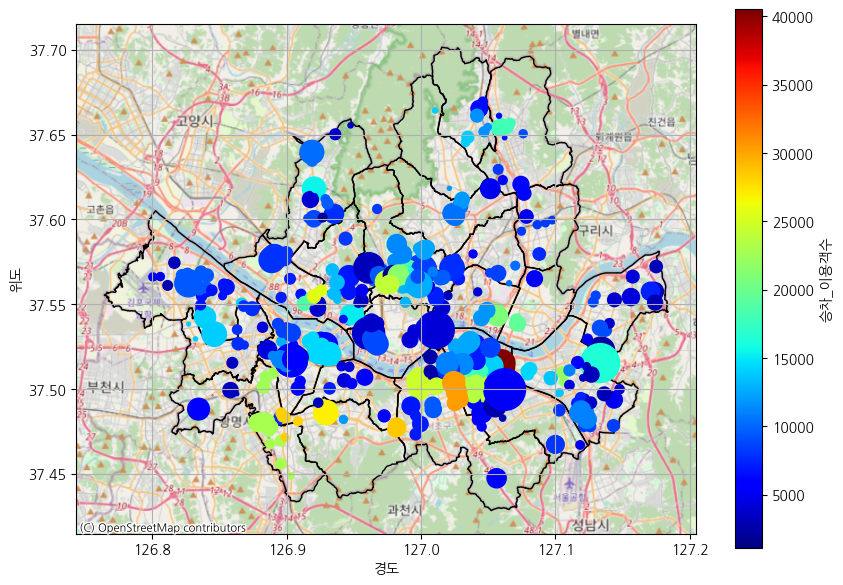

In [165]:
seoul_boundary = gpd.read_file("LARD_ADM_SECT_SGG_11_202502.shp")
seoul_boundary = seoul_boundary.to_crs(epsg=4326)


fig, ax = plt.subplots(figsize=(10, 7))

seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")


ctx.add_basemap(ax=ax, 
                crs=seoul_boundary.crs, 
                source=ctx.providers.OpenStreetMap.Mapnik)



df_starbucks.plot(
    ax=ax,
    kind='scatter',
    x='경도', y='위도',
    s=df_starbucks['평당거래금액(만원)']/10,
    c='승차_이용객수', cmap='jet', colorbar=True, grid=True)

In [181]:
df_new.columns

Index(['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '0세_6세', '7세_19세', '20세_25세',
       '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세', '평당거래금액(만원)',
       '스타벅스여부', '중심점거리', '중심점'],
      dtype='object')

In [ ]:
df_new = pd.concat([df_megamgc, df_starbucks], axis=0)
df_new = df_new[['상호명','경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '평당거래금액(만원)',
       '스타벅스여부', '중심점거리', '중심점','20세_25세','31세_40세','0세_6세']]
df_new = df_new.rename(columns={'평당거래금액(만원)':'평당거래금액',
                                '0세_6세': '나이0세_6세',
                                '20세_25세': '나이20세_25세',
                                '31세_40세': '나이31세_40세'})

# 메가커피와 스타벅스 커피를 분류하는 모델을 만들어보자
import statsmodels.api as sm
from statsmodels.formula.api import logit
# for col in df_new.columns:
#     cols += col + ' + '
# print(cols)

formula = '스타벅스여부 ~  근방가게수 + 근방음식점수 + 근방카페수 + 근접역거리 + 승차_이용객수 + 승차_출근시간대 + 승차_퇴근시간대 + 하차_이용객수 + 하차_출근시간대 + 하차_퇴근시간대 + 계 + 평당거래금액  + 중심점거리 + 나이20세_25세 + 나이31세_40세 + 나이0세_6세'

model = logit(data=df_new, formula=formula).fit()


Optimization terminated successfully.
         Current function value: 0.431235
         Iterations 7


In [197]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 스타벅스여부   No. Observations:                 1080
Model:                          Logit   Df Residuals:                     1063
Method:                           MLE   Df Model:                           16
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.3681
Time:                        16:37:51   Log-Likelihood:                -465.73
converged:                       True   LL-Null:                       -737.00
Covariance Type:            nonrobust   LLR p-value:                3.413e-105
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3982      0.616     -3.894      0.000      -3.605      -1.191
근방가게수         -0.0009      0.000     -6.943      0.000      -0.001      -0.001
근방음식점수         0.0024      0.001      3.481      0.0

In [200]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV

In [202]:
df_new = pd.concat([df_megamgc, df_starbucks], axis=0)
df_new = df_new[['상호명','경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '평당거래금액(만원)',
       '스타벅스여부', '중심점거리', '중심점','20세_25세','31세_40세','0세_6세']]
df_new = df_new.set_index('상호명')

In [216]:
# df_new 

num_attribs = df_new.select_dtypes(np.number).columns.to_list()
cat_attribs = df_new.select_dtypes('object').columns.to_list()
num_attribs.remove('스타벅스여부')

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

processor = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])


target = '스타벅스여부'
X = df_new.drop(target, axis=1)
y = df_new[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_idx = X_train.index
X_train = processor.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, index=X_train_idx, columns=processor.get_feature_names_out())

def transform_test(df):
    df_idx = df.index
    df = processor.transform(df).toarray()
    df = pd.DataFrame(df, index=df_idx, columns=processor.get_feature_names_out())
    return df

X_test = transform_test(X_test)

estimators = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42)
]


In [217]:
results = []
for model in estimators:
    name = model.__class__.__name__

    p = cross_val_predict(estimator=model,
                      X=X_train,
                      y=y_train,
                      method='predict_proba',
                      cv=5)
    threshold = 0.6
    tr_score = (p[:,1]>threshold).astype('int').mean()

    
    model.fit(X_train, y_train)
    y_p = model.predict_proba(X_test)[:,1]
    y_pred = (y_p > threshold).astype(int)
    ts_score = accuracy_score(y_test, y_pred)

    results.append({
        '모델': name,
        '훈련 정확도': tr_score,
        '테스트 정확도': ts_score
    })


In [218]:
results

[{'모델': 'RandomForestClassifier',
  '훈련 정확도': np.float64(0.2916666666666667),
  '테스트 정확도': 0.75},
 {'모델': 'XGBClassifier',
  '훈련 정확도': np.float64(0.4074074074074074),
  '테스트 정확도': 0.8055555555555556}]

In [219]:
best_model = XGBClassifier(random_state=42)
best_model.fit(X_train, y_train)
best_model.predict(X_test)

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [221]:
dir(best_model)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__sklearn_tags__',
 '__slotnames__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_create_dmatrix',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_iteration_range',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_load_model_attributes',
 '_more_tags',
 '_repr_html_',
 '

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

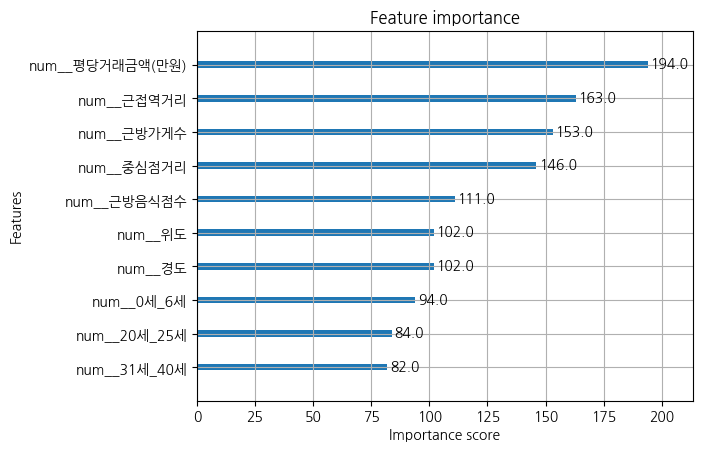

In [226]:
# sns.barplot(best_model.feature_importances_, x=best_model.feature_names_in_)
from xgboost import plot_importance
plot_importance(best_model, max_num_features=10)